In [73]:
from datasets import load_dataset
import torch
import numpy as np

In [74]:
dataset = load_dataset("x1101/nsfw-full", split="train")

In [75]:
from torchvision import transforms

In [89]:
image_size = 128

In [90]:
preprocess = transforms.Compose(
    [
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [91]:
def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

In [92]:
dataset.set_transform(transform)

In [93]:
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [94]:
batch = next(iter(train_dataloader))

In [95]:
import matplotlib.pyplot as plt
def show_batch(batch, batch_size=8, nrows=2):
    ncols = batch_size // nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axes = axes.flatten()

    for j in range(batch_size):
        img = batch[j]
        img = (img / 2 + 0.5).clamp(0, 1)
        img = img.detach().cpu().permute(1, 2, 0).numpy()
        
        axes[j].imshow(img)
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

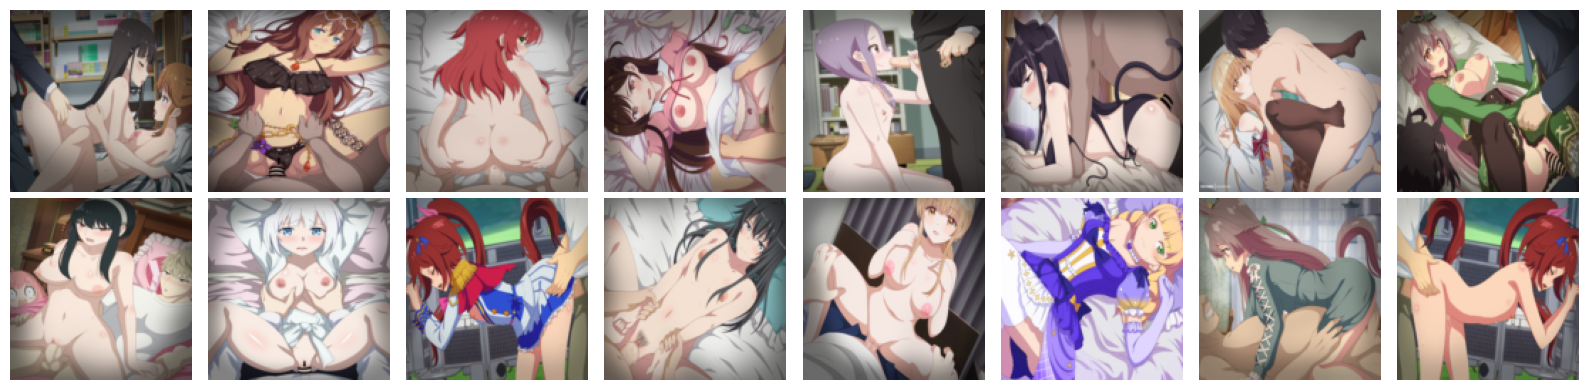

In [96]:
show_batch(batch["images"], batch_size=batch_size, nrows=2)

In [97]:
from diffusers import DDPMScheduler

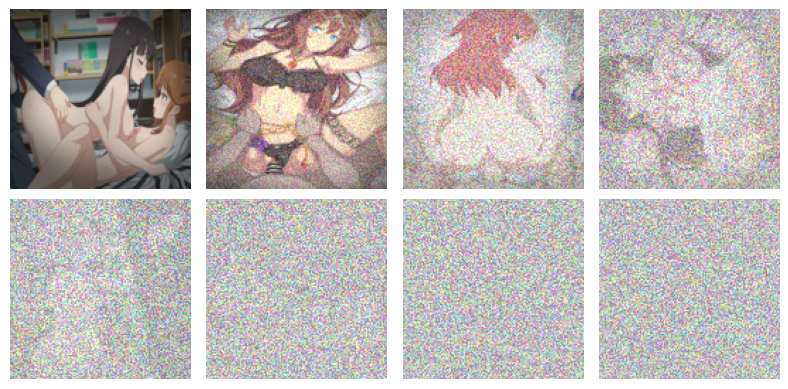

In [98]:
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)
timesteps = torch.linspace(0, 999, 8).long()
x = batch["images"][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_batch(noised_x, batch_size=8)

In [99]:
from diffusers import UNet2DModel
device = "cuda" if torch.cuda.is_available() else "cpu"

In [100]:
model = UNet2DModel(
    in_channels=3,
    sample_size=64,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

"DownBlock2D": convolution + downsample (stride=2)

"AttnDownBlock2D": convolution + attention layer + downsample

Ở đây, encoder có 2 block thường + 2 block attention → cho phép U-Net capture long-range dependencies (rất quan trọng trong diffusion model).

In [101]:
with torch.inference_mode():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample
print(noised_x.shape, out.shape)

torch.Size([8, 3, 128, 128]) torch.Size([8, 3, 128, 128])


In [102]:
from torch.nn import functional as F

In [103]:
num_epochs = 10
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []

In [104]:
for epoch in range(num_epochs):
    for batch in train_dataloader:
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (clean_images.shape[0],),device=device,).long()
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

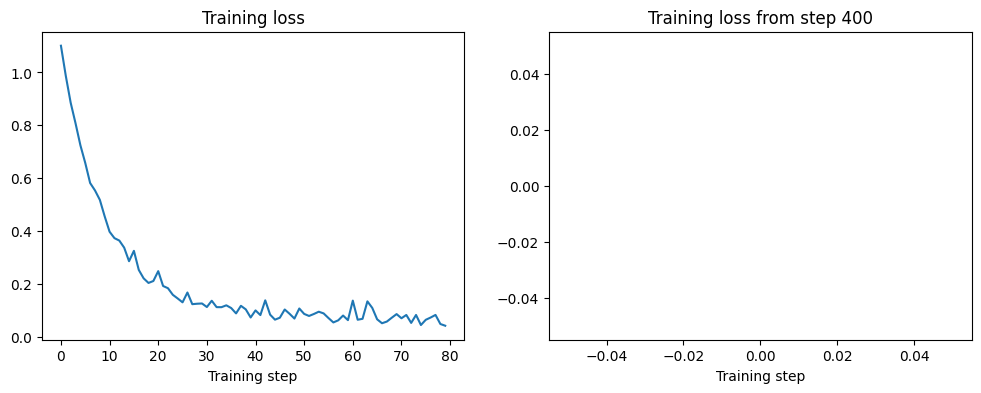

In [105]:
from matplotlib import pyplot as plt
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")
plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

In [106]:
from diffusers import DDPMPipeline
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images

  0%|          | 0/1000 [00:00<?, ?it/s]

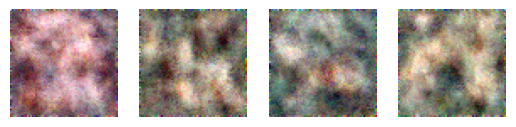

In [107]:
ims = np.array(ims)
for i in range(ims.shape[0]):
    plt.subplot(1, 4, i+1)
    plt.imshow(ims[i])
    plt.axis('off')